In [1]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#Functions


def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col, edgecolors='none',
                    colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])


def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(
        lambda x: h3.h3_to_parent(x, coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[
        [metric_col, ]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfc


def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]]
    dfk.index = dfk[hex_col]
    dfs = (dfk[hex_col]
           .apply(lambda x: pd.Series(list(h3.k_ring(x, k)))).stack()
           .to_frame('hexk').reset_index(1, drop=True).reset_index()
           .merge(df[[hex_col, metric_col]]).fillna(0)
           .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
           .reset_index()
           .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]

    # weighted smoothing
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K = len(coef)-1
    for k in range(1, K+1):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pd.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                      ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x: coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(
        index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


In [2]:
gdf = GeoDataFrame.from_file('./data/中国绿色发展指数2016.json')
gdf

,OBJECTID,PAC,NAME,排名,LSFZZS,ZYLYZS,HJZLZS,HJZLZS1,STBHZS,ZZZLZS,LSSHZS,GZMYD,geometry
0,1,460000,海南省,6,80.85,84.07,76.94,94.95,72.45,72.24,71.71,87.16,"MULTIPOLYGON (((113.22975 6.32326, 113.23262 6..."
1,8,530000,云南省,10,80.28,85.32,74.43,91.64,75.79,70.45,68.74,81.81,"POLYGON ((105.30651 27.70909, 105.30630 27.709..."
2,9,450000,广西壮族自治区,12,79.58,85.25,73.73,91.90,72.94,68.31,69.36,81.79,"MULTIPOLYGON (((109.20765 20.91986, 109.20747 ..."
3,11,440000,广东省,13,79.57,84.72,77.38,86.38,67.23,79.38,75.19,75.44,"MULTIPOLYGON (((110.59058 20.37940, 110.58608 ..."
4,14,810000,香港特别行政区,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"MULTIPOLYGON (((113.91438 22.16247, 113.91667 ..."
5,15,820000,澳门特别行政区,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"MULTIPOLYGON (((113.57286 22.16424, 113.56763 ..."
6,17,350000,福建省,2,83.58,90.32,80.12,92.84,74.78,74.55,73.65,87.14,"MULTIPOLYGON (((117.29337 23.59480, 117.29363 ..."
7,19,710000,台湾省,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"MULTIPOLYGON (((116.72242 20.70850, 116.72196 ..."
8,22,540000,西藏自治区,30,75.36,75.43,62.91,94.39,75.22,70.08,63.16,88.14,"POLYGON ((89.70974 36.09163, 89.70915 36.09181..."
9,24,510000,四川省,14,79.40,84.40,75.87,86.25,75.48,72.97,68.92,85.62,"POLYGON ((105.49807 32.91166, 105.49473 32.914..."


<AxesSubplot:>

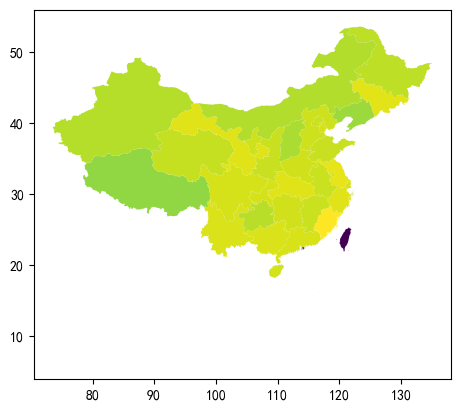

In [16]:
METRIC_COL = 'ZYLYZS'  # population density

# Load Census Tract (CT) ShapeFile
# gdf = GeoDataFrame.from_file('./data/中国绿色发展指数2016.json')
# gdf['gdf'] = gdf['code'].astype(str)

# Load CT Data & Join w/ ShapeFile
# df = pd.read_csv('南京市人口.csv', usecols=['code', METRIC_COL])
# # df['code'] = df['code'].astype(str)

# # join metadata
# gdf = df.merge(gdf).fillna(0)
# gdf.crs = {"init": "epsg:4326"}
# gdf.sample(3)
# gdf = GeoDataFrame(gdf)

# Visualize Population Density per Census Tract
# f, ax = plt.subplots(figsize=(5, 5))
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL, alpha=1, linewidth=0.05)


0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 
158 
159 
160 
161 
162 
163 
164 
165 
166 
167 
168 
169 
170 
171 
172 
173 
174 
175 
176 
177 
178 
179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
210 
211 
212 
213 
214 
215 
216 
217 
218 
219 
220 
221 


,OBJECTID,PAC,NAME,排名,LSFZZS,ZYLYZS,HJZLZS,HJZLZS1,STBHZS,ZZZLZS,LSSHZS,GZMYD,geometry,index_right,hex5,lat,lng
22,76,650000,新疆维吾尔族自治区,31,75.20,80.27,68.85,80.34,73.27,67.71,70.63,81.99,"POLYGON ((96.38537 42.72442, 96.36128 42.89654...",39964,8520e8abfffffff,44.115228,83.010020
23,86,620000,甘肃省,16,79.22,85.74,75.38,90.27,68.83,70.65,69.29,82.18,"POLYGON ((104.28564 37.42640, 104.28366 37.429...",26203,8524d24bfffffff,35.500682,103.164517
25,93,140000,山西省,26,76.78,78.87,80.55,77.51,70.66,71.18,78.34,73.16,"POLYGON ((113.73799 36.35959, 113.73776 36.358...",2672,85409dc3fffffff,34.842185,110.557642


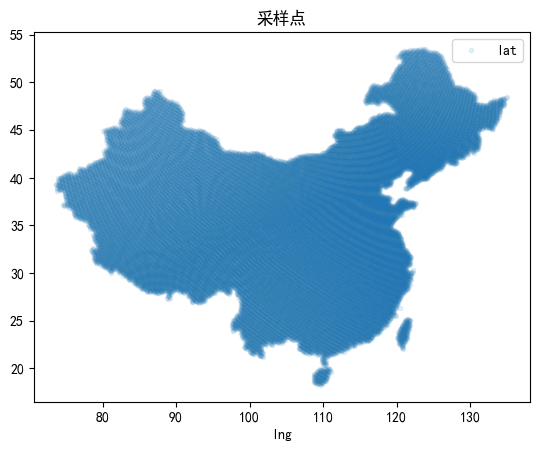

In [10]:
APERTURE_SIZE = 5
# Unify the CT boundries
union_poly = cascaded_union(gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list = []
if type(union_poly) == shapely.geometry.polygon.Polygon:
    union_poly = shapely.geometry.MultiPolygon([union_poly])
# print(type(union_poly))
for n, g in enumerate(union_poly):
    print(n, '\r')
    temp = mapping(g)
    temp['coordinates'] = [[[j[1], j[0]] for j in i]
                           for i in temp['coordinates']]
    hex_list.extend(h3.polyfill(temp, APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list, columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex
dfh['lat'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng, x.lat), 1)
dfh.crs = {"init": "epsg:4326"}

# plot hex latlng
dfh.plot(x='lng', y='lat', style='.', alpha=.1)
plt.title('采样点')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)


Text(0.5, 1.0, '采样点')

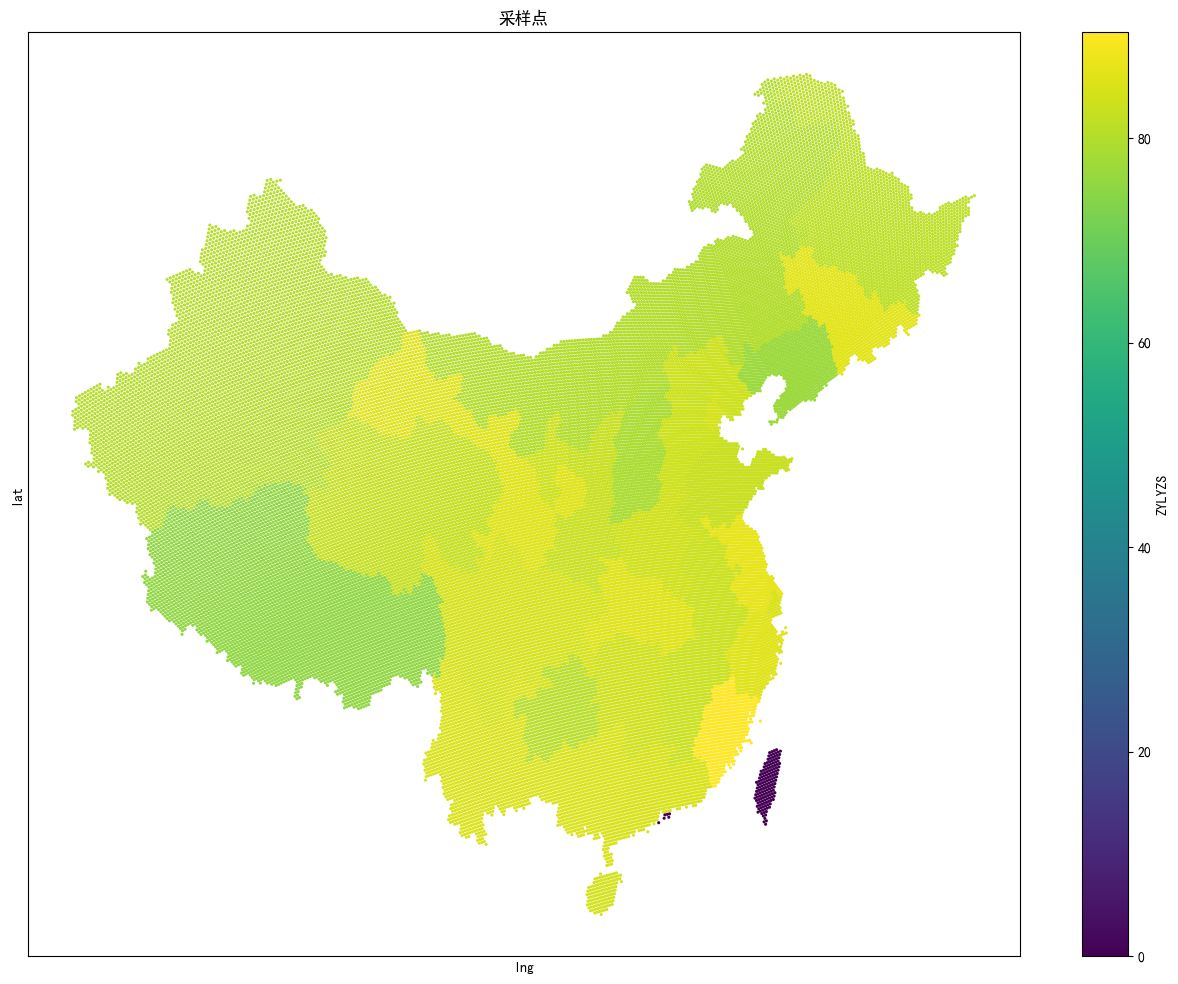

In [17]:
# Visualize Hexagons
plot_scatter(pd.DataFrame(df_ct), metric_col=METRIC_COL,
             marker='.')
plt.title('采样点')


sum sanity check: 0.9999984794600202


Text(0.5, 1.0, '利用克里金插值法进行插值')

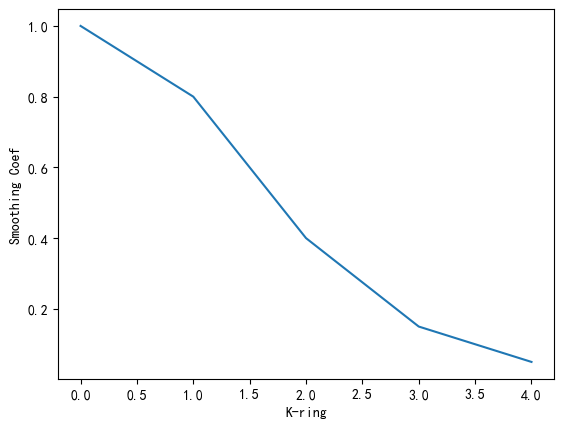

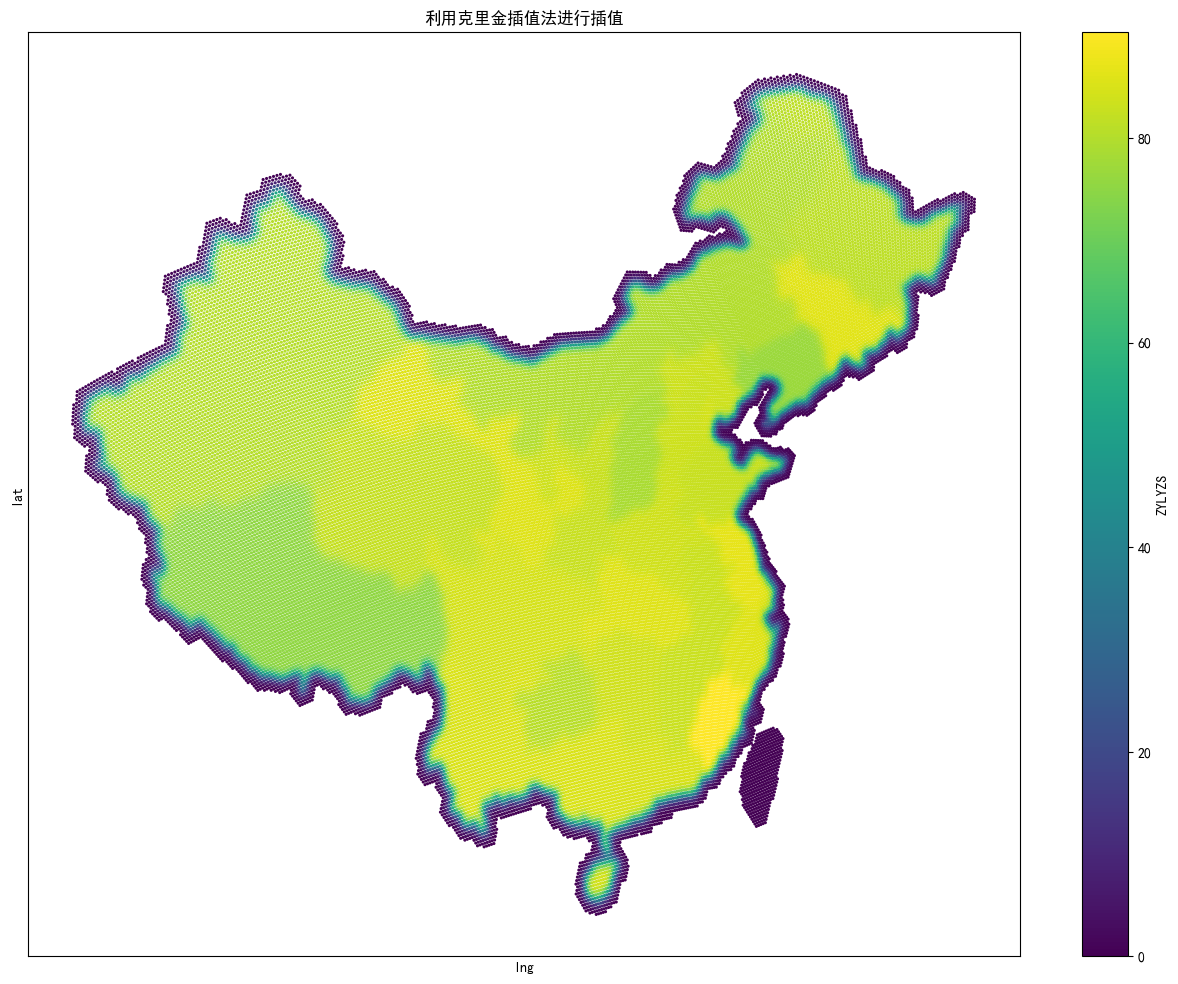

In [12]:
# 一跑就卡死电脑，不知道为啥
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(
    df_ct, hex_col, metric_col=METRIC_COL, coef=coef)
print('sum sanity check:',
      df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('利用克里金插值法进行插值')

number of hex: 46796
number of coarse hex: 46796


Text(0.5, 1.0, '数据空间化(分层层级5)')

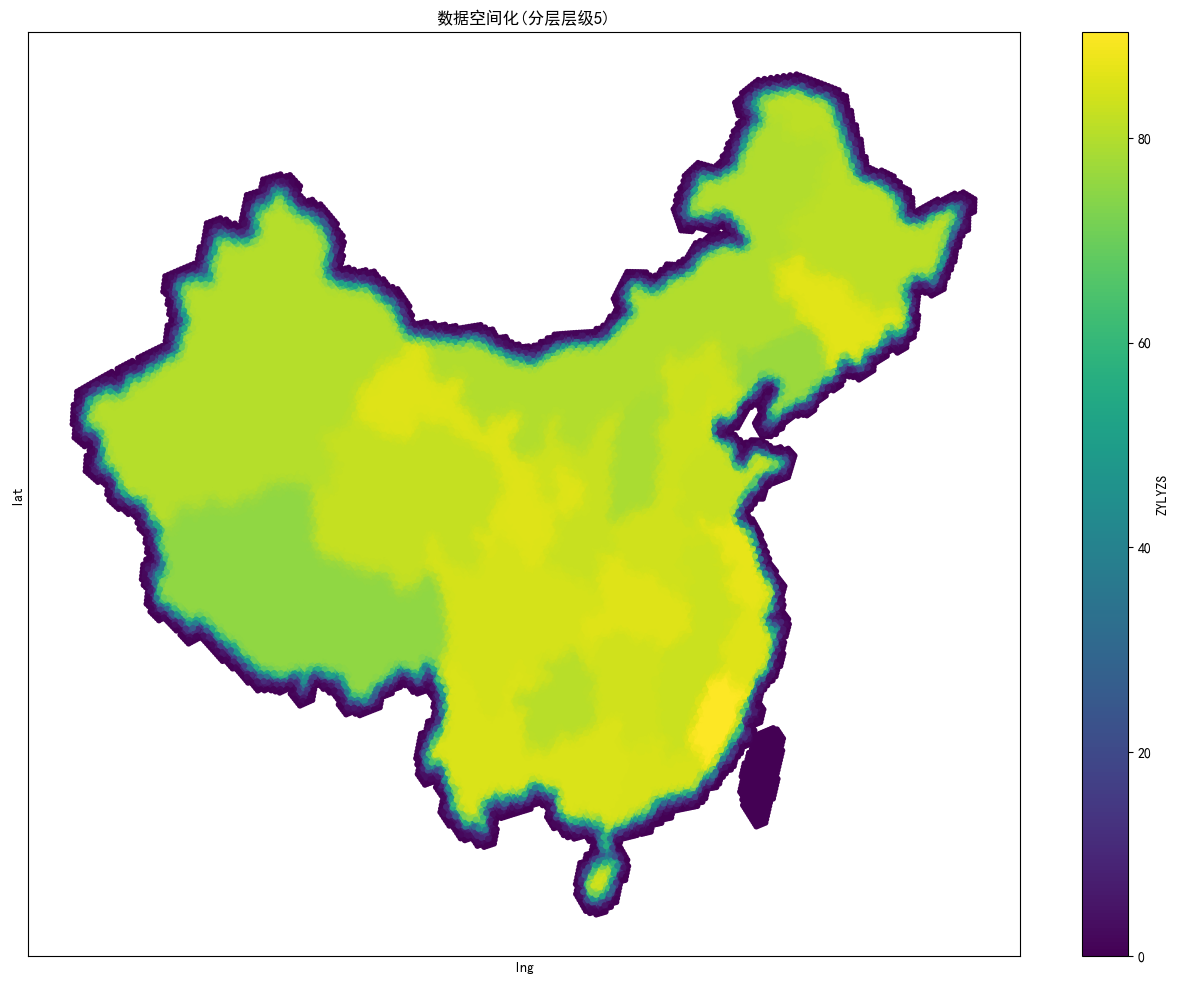

In [13]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 5
df_coarse = aperture_downsampling(
    df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))
plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
plt.title('数据空间化(分层层级5)')


In [14]:
df_ct_kw['hex7'].to_csv('hex7.csv', 'w', index=False)

In [20]:
df_ct_kw

,hex7,pop,lat,lng
0,873082480ffffff,0.015532,32.561328,119.022515
1,873082481ffffff,0.011095,32.561985,119.044787
2,873082482ffffff,0.062129,32.544186,119.015012
3,873082483ffffff,0.042159,32.544848,119.037284
4,873082484ffffff,0.004438,32.577806,119.007742
...,...,...,...,...
2739,87309edb2ffffff,0.539467,31.368673,119.053996
2740,87309edb3ffffff,0.541146,31.369511,119.076150
2741,87309edb4ffffff,0.522111,31.402770,119.046770
2742,87309edb5ffffff,0.526870,31.403604,119.068928


In [11]:
from shapely.geometry import Polygon
import json

geojson_out = {
    "type": "FeatureCollection",
    "features": []
}

for i in range(len(df_ct_kw)):
    geojson_out["features"].append({
        "type": "Feature",
        "properties": {
            "identifier": i
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                h3.h3_to_geo_boundary(df_ct_kw['hex7'][i], geo_json=True)
            ]
        },
        'properties': {
            "pop": df_ct_kw['pop'][i],
            "hex": df_ct_kw['hex7'][i]
        }
    })

# geojson_out
with open("./南京市人口插值.json", "w", encoding='utf-8') as outfile:
    json.dump(geojson_out, outfile, ensure_ascii=False, indent=4)


Text(0.5, 1.0, '南京市人口数据空间化(分层层级7)')

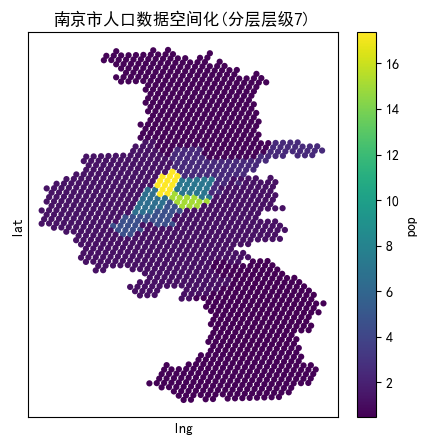

In [ ]:
# Aperture 7
_ = aperture_downsampling(
    df_ct, hex_col, metric_col=METRIC_COL, coarse_aperture_size=7)
plot_scatter(pd.DataFrame(_), metric_col=METRIC_COL,
             marker='o', figsize=(5, 5))
plt.title('南京市人口数据空间化(分层层级7)')


In [ ]:
from sklearn.linear_model import LinearRegression

# 读取已知数据
data = pd.read_csv('known_data.csv')

# 定义自变量和因变量
X = data[['longitude', 'latitude']]
y = data['pop']

# 建立线性回归模型
model = LinearRegression()
model.fit(X, y)

# 读取未知数据
new_data = pd.read_csv('unknown_data.csv')

# 对未知数据进行预测
new_data['predicted_population_density'] = model.predict(
    new_data[['longitude', 'latitude']])

# 将预测结果保存为csv文件
new_data.to_csv('predicted_data.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'known_data.csv'